In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup
import pathlib
base_dir = pathlib.Path("/Users/eyubogln/.meerkat/datasets/rfw/")

# Auditing Machine Learning Models with Meerkat 


In this demo, we’ll be using the Racial Faces in the Wild (RFW) dataset to audit AWS’s FaceCompare API. We provide predictions from the API on this dataset. Your task is to analyze model performance on this dataset and identify slices where the model is performing particularly poorly or particularly well.

In order to audit the API, we’ll be using a tool we’re developing that helps data scientists help wrangle and analyze unstructured data: it’s called Meerkat! Under the hood, it uses techniques like those described in Domino to identifying underperforming populations in machine learning datasets.

So, let’s import the Python package and get started!

In [3]:
import meerkat as mk

## Loading Data

Meerkat provides a [registry](https://meerkat.readthedocs.io/en/dev/datasets/datasets.html) of commonly used datasets, like RFW, which allows us to load the data into memory with one line of code.  We can then merge the dataset with a CSV containing the model predictions. 

In memory, the dataset and model predictions are stored in a [Meerkat DataPanel](https://meerkat.readthedocs.io/en/latest/guide/data_structures.html). A `DataPanel` is in many ways just like a Pandas DataFrame: it’s a tabular data structure made up of columns. Unlike a DataFrame though, the `DataPanel` is designed for unstructured data types like images and audio. As you can see in the table visualization below, there’s a column for the image, the false non-match rate (FNMR), id etc.


In [4]:
dp = mk.get("rfw")

**Loading CompareFaces Errors**. CompareFaces is an operation in Amazon Rekognition that predicts whether two images are taken of the same person. We've applied CompareFaces v6 (an AWS service) to the RFW dataset and stored the error rates for each image in the file `facecompare_v6_errors.csv`. Specifically, we've computed the *False Non-Match Rate* (FNMR) for each image, a measure of how often the model falsely predicts that two images are **not** of the same person.

<div>
<img src="fnmr.png" width="400"/>
</div>

We can load these error rates into our DataPanel with a single `DataPanel.merge` call which is equivalent to a `merge` in Pandas or a `join` in SQL. After doing this, we can see that the FNMR for each image is stored in the new `v6_fnmr` column.

,image_id (PandasSeriesColumn),identity (PandasSeriesColumn),ethnicity (PandasSeriesColumn),image (ImageColumn),v6_fnmr (PandasSeriesColumn)
0,m.0cqh0q_0001,m.0cqh0q,caucasian,,0.0
1,m.0cqh0q_0003,m.0cqh0q,caucasian,,0.0
2,m.0cqh0q_0004,m.0cqh0q,caucasian,,0.0

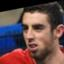
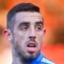
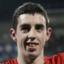

In [5]:
dp = dp.merge(
	mk.DataPanel.from_csv(base_dir / "themis/facecompare_v6_errors.csv"),
	on="image_id",
)
dp.head(3)

There are a number of operations that can be performed on a `DataPanel`, for example, we can use `sample` to randomly shuffle the dataset. 

In [6]:
dp = dp.sample(frac=1, replace=False)

## Exploring the Dataset

To help with explore datasets with unstructured data types (*e.g.* images), Meerkat allows you to spin up interactive GUIs from within your notebook. These visualizations allow you to efficiently explore large image, audio, and video datasets. 

Note that the visualizations are highly customizable. There are a few different interface types (*e.g.  “*gallery”, “table”, “plot”) that can be customized from within the notebook.  See the documentation for a full list of interfaces. 

First though, we'll have to execute the two cells below to launch the interactive mode. 

In [ ]:
network, register_api = mk.interactive_mode()

In [ ]:
register_api()

To begin, understanding the errors, we'll sort the DataPanel by the FNMR column and then launch a new interface. 

In [9]:
# dp = dp.sort(by="v6_fnmr", ascending=False) 

dp.gui.table()

## Computing global metrics
Next we’ll  compute some average metrics across the entire dataset to get a sense of how the model is performing globally.

In [11]:
global_fnmr = dp["v6_fnmr"].mean()
print(f"Global False Non-Match Rate: {global_fnmr: .2%}")

Global False Non-Match Rate:  2.28%


## Computing group statistics

RFW provides annotations for limited set of high-level racial groups. In ths section, we’ll see how performance varies when stratifying by these groups. To do so, we’ll use `mk.groupby`.

In [12]:
gb = dp.groupby("ethnicity")
gb["v6_fnmr"].mean()

,v6_fnmr (NumpyArrayColumn),ethnicity (PandasSeriesColumn)
0,0.011853,african
1,0.028925,asian
2,0.028373,caucasian
3,0.022784,indian


In [13]:
dp["v6_fnmr"].std()

0.11053119731272452

We can also visualize the groups in a `GroupBy` with the `cards` interface:

In [14]:
gb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

Mean FNMR
56180478c7dd4a369d1bcc524aa3a4cc
STD FNMR
c1a3dba198094bb29bbd47258582cb64
Size
d2e69bbd82994ef9b99bdb5c355f2db1
{
  'Mean FNMR': {
    dp: {
      african: ' 0.011853',
      asian: ' 0.028925',
      caucasian: ' 0.028373',
      indian: ' 0.022784'
    }
  },
  'STD FNMR': {
    dp: {
      african: ' 0.080372',
      asian: ' 0.120433',
      caucasian: ' 0.123075',
      indian: ' 0.113152'
    }
  },
  Size: {
    dp: {
      african: ' 10414',
      asian: ' 9687',
      caucasian: ' 10194',
      indian: ' 10307'
    }
  }
}


## Going beyond available metadata... 

The trouble is, the subgroup annotations provided in RFW are quite limited. What if there are other groups that we'd like to explore for which we lack annotations?

This is where things start to get interesting: we are goinng to use large, pretrained models in order to bootstrap our dataset with more metadata! This is the key idea behind Meerkat.

To demonstrate this idea, we've implemented the `match` operation in the GUI. With `match`, we can create new columns by writing natural language queries and matching them to the images. For example, say we want a metadata column that tells us whether the person in the image is wearing sunglasses. We can write a query like: "A person wearing sunglasses."

Let's try it out below. First, we'll need to `embed` the images into a latent space using a pretrained encoder (e.g. CLIP). Meerkat includes a registry of available encoders, so we can just specify one in the `mk.embed` call.

In [15]:
# In practice, columns can be embedded using `mk.embed`, however, for time's sake, we'll 
# just merge in the embeddings below
# dp = mk.embed(dp, input="image", num_workers=0, encoder="clip", device=0)

dp = dp.merge(
    mk.DataPanel.read(base_dir / "main/rfw_embedded.mk")["image_id", "clip(image)"],
    on="image_id"
)

## Going beyond available metadata... 

The trouble is, the subgroup annotations provided in RFW are quite limited. What if there are other groups that we'd like to explore for which we lack annotations?

This is where things start to get interesting: we are goinng to use large, pretrained models in order to bootstrap our dataset with more metadata! This is the key idea behind Meerkat.

To demonstrate this idea, we've implemented the `match` operation in the GUI. With `match`, we can create new columns by writing natural language queries and matching them to the images. For example, say we want a metadata column that tells us whether the person in the image is wearing sunglasses. We can write a query like: "A person wearing sunglasses."

Let's try it out below. First, we'll need to `embed` the images into a latent space using a pretrained encoder (e.g. CLIP). Meerkat includes a registry of available encoders, so we can just specify one in the `mk.embed` call.

In [16]:
dp.gui.table()

  0%|          | 0/1 [00:00<?, ?it/s]

Matching produces a continuous score for each image in the dataset. We'd like to find a *threshold score* above which people are wearing sunglasses. Using the gallery view we can find this threshold quite easily. 

In [ ]:
#_we need to find the threshold 
dp = dp["sunglasses"] > 0.25

In [ ]:

dp.gui.plot(suggestions=[sb, "pca", "umap"])

## Discovering slices

The subgroup annotations provided in RFW are quite limited, so we’ll use meerkat to *discover* new slices. To do so, we’ll use `dp.explainby`, a method that identifies a set of slices (*i.e.* scalar functions of the `by` column) that explain the variance in the response variable.

In [ ]:
from meerkat.ops.sliceby.explainby import explainby
eb = explainby(dp, by="image", target="v6_fnmr",  n_slices=10)

In [ ]:
eb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr", "ethnicity"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

In [27]:
cb = dp.clusterby(by="image")
cb.gui.cards(
    main_column="image", 
    tag_columns=["v6_fnmr", "ethnicity"],
    aggregations={
        "Mean FNMR": lambda x: x["v6_fnmr"].mean(),
        "STD FNMR": lambda x: x["v6_fnmr"].std(),
        "Size": len,
    }
)

{}
Mean FNMR
88ee3bf064d84aa790c3eb35f91418c1
STD FNMR
37e23ad83c9d447fbc1f8902817fb873
Size
e3e307ee59934a82bb3f6b58edad99a5
{
  'Mean FNMR': {
    dp: {
      african: ' 0.011853',
      asian: ' 0.028925',
      caucasian: ' 0.028373',
      indian: ' 0.022784'
    }
  },
  'STD FNMR': {
    dp: {
      african: ' 0.080368',
      asian: ' 0.120427',
      caucasian: ' 0.123069',
      indian: ' 0.113147'
    }
  },
  Size: {
    dp: {
      african: ' 10414',
      asian: ' 9687',
      caucasian: ' 10194',
      indian: ' 10307'
    }
  }
}


## Diving deeper

In practice, the slices discovered in the previous section should serve as inspiration for further exploration. One great way to quickly continue exploring other slices is via the plot interface. Unlike standard plotting interfaces, you can actually manipulate the axes and add labels for columns that don’t yet exist. For example, TODO add labeling example.

Now we can using the plotting view, we can use it plot anything in our data. Matching + slicing allows to better understand what a slice is. 

People singing vs. people singing into a microphone. 

In [ ]:
dp.gui.plot(suggestions=[sb, "pca", "umap"])

In [ ]:
https://www.loom.com/share/9bde7342c0ad4a6290fffe5e322134f3

## 

So a lot of the stuff that we found, folks on this team have documented (e.g. hats)
BUt, hopefully this demo demonstrates that we can like rediscover this very fast. 

We want to take this 

This is research: There are a lot of issues with the tool, because based off of flawed models with unkown accuracy. 
Part of this is to motivate how the underlying stuff needs to improve. 
How to make the results actionable. And how to certify the findings. 

Why are we taking this route of building the interaction in – as opposed to developing a better slice discovery method etc. 
The methods are never going to be perfect, need to have a hands of the wheel mentality. 

How to blend interaction into that research. 


Explain to them what we're up to: this is an initial prototype of low hanging fruit. 